In [1]:
# !pip install contractions

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 284 kB 1.4 MB/s eta 0:00:01


In [2]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-02-27 05:56:43--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.92.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.92.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  3.36MB/s    in 11m 5s  

2022-02-27 06:07:50 (2.36 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [3]:
# !gzip -vd "GoogleNews-vectors-negative300.bin.gz"

GoogleNews-vectors-negative300.bin.gz:	   54.8% -- replaced with GoogleNews-vectors-negative300.bin


In [4]:
# !pip install gensim

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 24.0 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 3.4 MB/s eta 0:00:01


In [46]:
from gensim import models

word2vec_model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [47]:
word2vec_model['king'].shape

(300,)

In [8]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"

--2022-02-27 06:19:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  2.58MB/s    in 23s     

2022-02-27 06:19:31 (1.77 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]



In [9]:
!unzip "drugsCom_raw.zip"

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [62]:
import numpy as np
import pandas as pd

df = pd.read_table('drugsComTrain_raw.tsv')
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [63]:
df = df[['review', 'condition']]
df.head()

,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence


In [79]:
# !pip install fuzzywuzzy
!pip install python-Levenshtein

Defaulting to user installation because normal site-packages is not writeable
  Using cached python-Levenshtein-0.12.2.tar.gz (50 kB)
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp38-cp38-macosx_10_9_x86_64.whl size=81474 sha256=eb2f487d376c1e121ee62df9191bc8b348b15df64d48671a922025b432e5ef62
  Stored in directory: /Users/kkvp639/Library/Caches/pip/wheels/d7/0c/76/042b46eb0df65c3ccd0338f791210c55ab79d209bcc269e2c7
Successfully built python-Levenshtein


In [69]:
unique_conditions = df['condition'].str.lower().dropna().unique().tolist()
len(unique_conditions)

884

In [85]:
from fuzzywuzzy import fuzz


def identify_condition(text):
    text = text.lower()
    match_conditions = [c for c in unique_conditions if fuzz.token_set_ratio(text, c.lower()) > 70]
    return match_conditions

identify_condition("Birth control is.")

['birth control']

In [86]:
found_conditions = df['review'].apply(identify_condition)

KeyboardInterrupt: 

In [70]:
# df['found_conditions'] = df['review'].str.lower().apply(lambda x: x if x in unique_conditions else '')
df['found_conditions'] = found_conditions

In [72]:
df[df['found_conditions'] != ''].shape

(0, 3)

In [67]:
top_10_conditions = df['condition'].value_counts().head(10).index.tolist()
top_10_conditions

['Birth Control',
 'Depression',
 'Pain',
 'Anxiety',
 'Acne',
 'Bipolar Disorde',
 'Insomnia',
 'Weight Loss',
 'Obesity',
 'ADHD']

<AxesSubplot:>

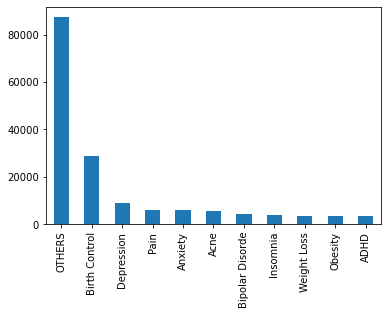

In [4]:
df['condition'] = df['condition'].apply(lambda x: x if x in top_10_conditions else 'OTHERS')
df['condition'].value_counts().plot(kind='bar')

In [5]:
import re
import html
import contractions

def remove_chars(text):
    text = html.unescape(text)
    text = contractions.fix(text)
    # remove_chars = r'&amp;|\u200b|\x7f|\x11'
    remove_chars_1 = r'[^A-Za-z0-9 ]'
    remove_chars_2 = r'^"'
    remove_chars_3 = r'"$'
    more_than_two_spaces = r'[\s\s]+'
    # text = re.sub(remove_chars, ' ', text)
    # text = re.sub(remove_chars, ' ', text)
    text = re.sub(remove_chars_1, ' ', text)
    text = re.sub(remove_chars_2, ' ', text)
    text = re.sub(remove_chars_3, ' ', text)
    text = re.sub(more_than_two_spaces, ' ', text)
    return text.strip()


df['cleaned_text'] = df['review'].apply(remove_chars)

In [6]:
# df_spacy_vectors[0][0]

In [50]:
# Text to word embedding

def get_sentence_vector(text):
    words = [word for word in text.split() if word in word2vec_model]
    if len(words) >= 1:
        a = np.mean(word2vec_model[words], axis=0)
        return np.mean(word2vec_model[words], axis=0)
    else:
        return np.zeros(300)

# df_doc_vectors = df['cleaned_text'].apply(get_sentence_vector)
df_doc_vectors = df_spacy_vectors[0].apply(get_sentence_vector)
df_doc_vectors = np.row_stack(df_doc_vectors)
df_doc_vectors = pd.DataFrame(df_doc_vectors)
df_doc_vectors.shape

(161297, 300)

In [75]:
df['cleaned_text'][0]

'it has no side effect i take it in combination of bystolic 5 mg and fish oil'

In [76]:
!pip install -U spacy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.2 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 722 kB/s eta 0:00:01
     |████████████████████████████████| 609 kB 880 kB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 1.8 MB/s eta 0:00:01
  Using cached pydantic-1.8.2-cp38-cp38-macosx_10_9_x86_64.whl (2.6 MB)
     |████████████████████████████████| 42 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 450 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 2.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [79]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 2.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
import spacy

spacy_model = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [8]:
sentence = spacy_model('Latest Rumours: Manchester United is looking to sign Harry Kane for $90 million')  
sentence

Latest Rumours: Manchester United is looking to sign Harry Kane for $90 million

In [9]:
def spacy_features(text):
    text = spacy_model(text)
    token_features = {'norm_text': '', 'noun_counts': 0, 'digits_counts': 0, 'lower_counts': 0, 'upper_counts': 0, 'title_counts': 0, 'total_words': 0}
    for token in text:
        if token.pos_ in ['NOUN', 'PROPN']:
            token_features['noun_counts'] += 1
        if token.is_digit:
            token_features['digits_counts'] += 1
        if token.is_lower:
            token_features['lower_counts'] += 1
        if token.is_upper:
            token_features['upper_counts'] += 1
        if token.is_title:
            token_features['title_counts'] += 1
        token_features['total_words'] = len(text)
        token_features['norm_text'] += token.lemma_ + ' '
    token_features['norm_text'] = token_features['norm_text'].lower().strip()
#     token_features['noun_phrase_counts'] = len(list(text.noun_chunks))
        
    return list(token_features.values())

spacy_features("Latest Rumours: Manchester United is looking to sign Harry Kane for $90 million")

['late rumour : manchester united be look to sign harry kane for $ 90 million',
 5,
 1,
 6,
 0,
 6,
 15]

In [11]:
df_spacy_vectors = df['cleaned_text'].apply(spacy_features)
df_spacy_vectors = np.row_stack(df_spacy_vectors)
df_spacy_vectors = pd.DataFrame(df_spacy_vectors)
df_spacy_vectors.to_csv('spacy_features.csv', index=False) # saved
df_spacy_vectors.head()

,0,1,2,3,4,5,6
0,it have no side effect i take it in combinatio...,5,1,10,1,6,17
1,my son be halfway through his fourth week of i...,24,1,126,2,13,141
2,i use to take another oral contraceptive which...,35,2,118,6,15,136
3,this be my first time use any form of birth co...,20,5,77,5,10,92
4,suboxone have completely turn my life around i...,27,0,112,9,17,129


In [14]:
df_spacy_vectors = pd.read_csv(r'/Users/kkvp639/Untitled Folder/spacy_features.csv')
df_spacy_vectors.head()

,0,1,2,3,4,5,6
0,it have no side effect i take it in combinatio...,5,1,10,1,6,17
1,my son be halfway through his fourth week of i...,24,1,126,2,13,141
2,i use to take another oral contraceptive which...,35,2,118,6,15,136
3,this be my first time use any form of birth co...,20,5,77,5,10,92
4,suboxone have completely turn my life around i...,27,0,112,9,17,129


In [160]:
# !pip install pandas==1.4.1

Defaulting to user installation because normal site-packages is not writeable


In [142]:
df['cleaned_text'].head()

0    It has no side effect I take it in combination...
1    My son is halfway through his fourth week of I...
2    I used to take another oral contraceptive whic...
3    This is my first time using any form of birth ...
4    Suboxone has completely turned my life around ...
Name: cleaned_text, dtype: object

In [15]:
# Max length of sentence
max_length = df['cleaned_text'].str.split().str.len().max()
max_length

1915

In [16]:
df['len_of_sentences'] = df['cleaned_text'].str.split().str.len()

In [ ]:
# df['len_of_sentences'].value_counts().rename_axis('len_of_sentences').reset_index(name='counts').sort_values(['len_of_sentences'], ascending=False).head(5)

In [ ]:
# # Drop sentences having length less than 3 and greater than 160
# df = df[(df['len_of_sentences'] > 3) & (df['len_of_sentences'] < 160)]

# df = df[['cleaned_text', 'condition']]
# df.head()

In [28]:
token_frequency = df['cleaned_text'].str.split(expand=True).stack().value_counts()
token_frequency

i              858990
and            431805
the            407273
to             323935
it             317852
                ...  
isotrention         1
moxicam             1
valvular            1
dervovat            1
liquors             1
Length: 49826, dtype: int64

In [29]:
token_frequency.reset_index().to_csv('token_frequency.csv', index=False)

In [20]:
# vocab list
vocabs = token_frequency.index.tolist()
len(vocabs)

120923

In [55]:
# vocabs

In [47]:
y = df['condition']
y.shape

(161297,)

In [66]:
df['cleaned_text'][0]

'it has no side effect i take it in combination of bystolic 5 mg and fish oil'

In [67]:
df_doc_vectors.shape

(161297, 300)

In [68]:
df_doc_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.052830,0.015339,0.003952,0.079677,-0.005110,-0.025721,0.018908,-0.149179,0.042402,0.143101,...,-0.079123,0.018127,-0.026550,0.031747,0.007174,0.021375,-0.000907,-0.022369,0.066864,-0.020067
1,0.059747,0.034659,0.010716,0.077803,-0.034158,-0.027779,0.025628,-0.092481,0.085159,0.052338,...,-0.070709,0.014049,-0.076728,0.028506,-0.041021,0.016416,-0.022501,-0.024456,0.050150,-0.013008
2,0.002578,0.034985,0.014468,0.072590,-0.040199,-0.039970,0.043476,-0.098582,0.086415,0.081547,...,-0.056099,0.046963,-0.078435,0.017149,-0.010902,0.001944,-0.031923,-0.022010,0.029561,-0.030694
3,0.008701,0.024249,0.014001,0.092215,-0.043254,-0.014922,0.033034,-0.115724,0.077667,0.065638,...,-0.063228,0.065326,-0.069859,-0.011955,-0.019159,-0.007370,-0.076627,-0.019015,-0.016564,-0.034399
4,0.023833,0.021453,0.023152,0.102609,-0.031780,0.011804,0.029739,-0.081432,0.055178,0.065804,...,-0.086269,0.066978,-0.103322,0.016077,-0.047233,-0.001571,-0.007635,-0.021095,0.026196,-0.018204


,0,1,2,3,4,5,6
0,it have no side effect i take it in combinatio...,5,1,10,1,6,17
1,my son be halfway through his fourth week of i...,24,1,126,2,13,141


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_text'])
print(X.shape)

(159040, 1144412)


In [ ]:
from sklearn.feature_selection import chi2

chi2score = chi2(X, y)[0]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, '$\\chi^2$')

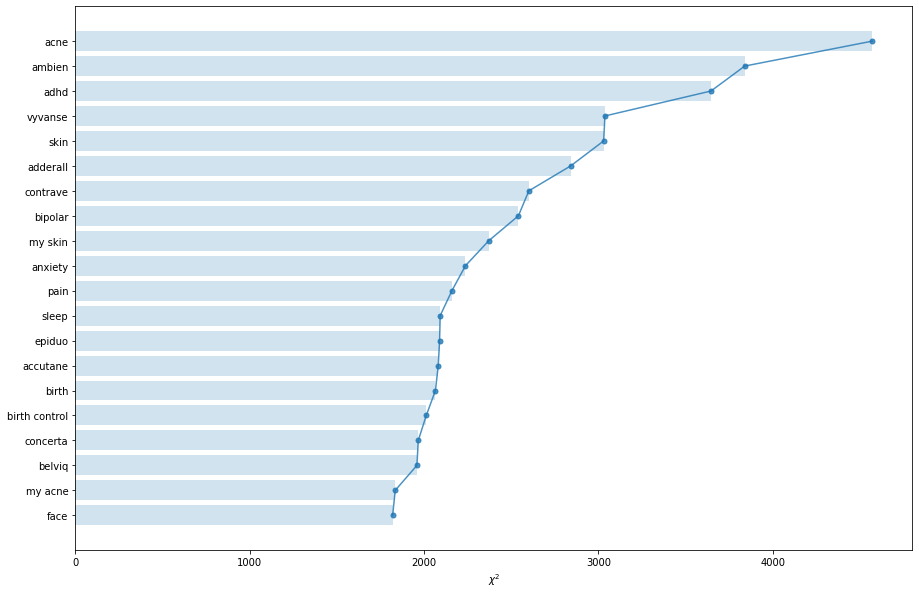

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [ ]:
# from sklearn.decomposition import TruncatedSVD

# pca = TruncatedSVD(n_components=100)
# pca.fit_transform(X)
# pca.explained_variance_

array([0.00223739, 0.00207957, 0.00177648, 0.00148694, 0.00128517,
       0.00122366, 0.00115639, 0.00106905, 0.00102458, 0.0009616 ,
       0.00092749, 0.00088808, 0.00087335, 0.00084116, 0.00080473,
       0.00079681, 0.00077852, 0.00075757, 0.00073873, 0.00072096,
       0.00070479, 0.0006989 , 0.00067988, 0.00067432, 0.00066423,
       0.00065937, 0.00065126, 0.00063791, 0.00063282, 0.00061225,
       0.00059863, 0.00058915, 0.00058286, 0.00057907, 0.00056974,
       0.00056275, 0.00055313, 0.0005457 , 0.00053866, 0.00053546,
       0.0005324 , 0.00052562, 0.00052407, 0.00052292, 0.00051311,
       0.00050733, 0.00050236, 0.00049313, 0.00048845, 0.00048267,
       0.00048041, 0.00047602, 0.00047358, 0.00046625, 0.00046301,
       0.00045687, 0.00045284, 0.00045062, 0.00044787, 0.00044331,
       0.00043832, 0.00043437, 0.00043322, 0.00042598, 0.00041998,
       0.00041837, 0.0004118 , 0.0004099 , 0.00040798, 0.00040382,
       0.00039916, 0.00039662, 0.00039344, 0.00039167, 0.00038

In [69]:
X = df_doc_vectors

In [24]:
df_spacy_vectors.shape

(161297, 7)

In [27]:
# drop na row
df_spacy_vectors = df_spacy_vectors[~df_spacy_vectors['0'].isna()]
df_spacy_vectors.shape

(161295, 7)

In [28]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(ngram_range=(1, 3), n_features=2 ** 18)
X = vectorizer.fit_transform(df_spacy_vectors['0'])
print(X.shape)

(161295, 262144)


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_spacy_vectors[['1', '2', '3', '4', '5', '6']])
X_scaled.shape

(161295, 6)

In [33]:
X

<161295x262144 sparse matrix of type '<class 'numpy.float64'>'
	with 32834674 stored elements in Compressed Sparse Row format>

In [34]:
from scipy import sparse
sparse_X_scaled = sparse.csr_matrix(X_scaled)
sparse_X_scaled

<161295x6 sparse matrix of type '<class 'numpy.float64'>'
	with 905031 stored elements in Compressed Sparse Row format>

In [ ]:
# from scipy.sparse import hstack

# X1 = hstack((X, sparse_doc_vectors, sparse_X_scaled))
# X1

In [37]:
from scipy.sparse import hstack

X1 = hstack((X, sparse_X_scaled))
X1

<161295x262150 sparse matrix of type '<class 'numpy.float64'>'
	with 33739705 stored elements in COOrdinate format>

In [43]:
X1.getcol(2)

<161295x1 sparse matrix of type '<class 'numpy.float64'>'
	with 64 stored elements in Compressed Sparse Row format>

In [55]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y

array([7, 0, 4, ..., 7, 7, 7])

In [56]:
set(y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [36]:
# !pip install mlxtend

In [57]:
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

pipe1 = make_pipeline(ColumnSelector(cols=tuple(range(0, 262144))),
                      LinearSVC(verbose=1))
pipe2 = make_pipeline(ColumnSelector(cols=tuple(range(262144, 262150))),
                      LinearSVC(verbose=1))

sclf = StackingClassifier(classifiers=[pipe1, pipe2], 
                          meta_classifier=LinearSVC(),
                         verbose=2)

sclf.fit(X1.tocsr(), y[:161295])

Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Pipeline(steps=[('columnselector',
                 ColumnSelector(cols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                      13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                      23, 24, 25, 26, 27, 28, 29, ...))),
                ('linearsvc', LinearSVC(verbose=1))])
[LibLinear]....*
optimization finished, #iter = 49
Objective value = -5306.409624
nSV = 39229
....*
optimization finished, #iter = 48
Objective value = -7888.262896
nSV = 45455
....*
optimization finished, #iter = 49
Objective value = -10881.144414
nSV = 56052
....*
optimization finished, #iter = 47
Objective value = -7425.194130
nSV = 48734
....*.
optimization finished, #iter = 50
Objective value = -35528.706154
nSV = 105387
....*
optimization finished, #iter = 49
Objective value = -16387.652961
nSV = 70233
....*
optimization finished, #iter = 48
Objective value = -5926.659419
nSV = 37738
.....*
optimization f

/Users/kkvp639/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


StackingClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                 ColumnSelector(cols=(0, 1, 2,
                                                                      3, 4, 5,
                                                                      6, 7, 8,
                                                                      9, 10, 11,
                                                                      12, 13,
                                                                      14, 15,
                                                                      16, 17,
                                                                      18, 19,
                                                                      20, 21,
                                                                      22, 23,
                                                                      24, 25,
                                                                     

In [49]:
# y[:161295].shape

(161295,)

In [59]:
from sklearn.metrics import accuracy_score

y_pred = sclf.predict(X1.tocsr())

accuracy_score(y[:161295], y_pred)

0.6723581016150532

In [51]:
sparse_doc_vectors = sparse.csr_matrix(df_doc_vectors)
sparse_doc_vectors

<161297x300 sparse matrix of type '<class 'numpy.float64'>'
	with 48386523 stored elements in Compressed Sparse Row format>

<161297x1048882 sparse matrix of type '<class 'numpy.float64'>'
	with 82137096 stored elements in COOrdinate format>

In [41]:
X

<161297x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 32845299 stored elements in Compressed Sparse Row format>

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33, random_state=42, stratify=y)

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((108068, 1048882), (53229, 1048882), (108068,), (53229,))

In [55]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

clf = LinearSVC(random_state=25, class_weight='balanced', verbose=1)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('Training accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))

[LibLinear].....................................*
optimization finished, #iter = 378
Objective value = -2130.147970
nSV = 12516
..........................*.*
optimization finished, #iter = 271
Objective value = -2414.819184
nSV = 11751
..................................*
optimization finished, #iter = 344
Objective value = -6355.758584
nSV = 23450
................................*
optimization finished, #iter = 328
Objective value = -4195.006201
nSV = 20786
...............*.*
optimization finished, #iter = 161
Objective value = -5877.286224
nSV = 27860
........................................*
optimization finished, #iter = 402
Objective value = -8376.461075
nSV = 30535
...................................................*
optimization finished, #iter = 514
Objective value = -2807.493256
nSV = 12099
..........................*................**.
optimization finished, #iter = 430
Objective value = -13268.400729
nSV = 82296
........................................................*.......

In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

                 precision    recall  f1-score   support

           ADHD       0.86      0.88      0.87      1116
           Acne       0.90      0.92      0.91      1844
        Anxiety       0.62      0.73      0.67      1948
Bipolar Disorde       0.74      0.78      0.76      1394
  Birth Control       0.89      0.97      0.93      9500
     Depression       0.65      0.79      0.71      2993
       Insomnia       0.75      0.84      0.79      1212
         OTHERS       0.93      0.86      0.89     28825
        Obesity       0.74      0.74      0.74      1178
           Pain       0.69      0.75      0.72      2028
    Weight Loss       0.76      0.75      0.76      1191

       accuracy                           0.86     53229
      macro avg       0.78      0.82      0.80     53229
   weighted avg       0.87      0.86      0.86     53229



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('Training accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))